<a href="https://colab.research.google.com/github/AmrMKayid/KayFast/blob/master/lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.607447,0.977912,00:00
1,0.849344,0.677177,00:00
2,0.667005,0.674286,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
path=Config.data_path()/'ml-100k'

In [22]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [24]:
len(ratings)

100000

In [25]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [27]:
data.show_batch()

userId,title,target
738,"Lost World: Jurassic Park, The (1997)",4.0
940,"Abyss, The (1989)",2.0
643,"Boot, Das (1981)",4.0
624,Beautiful Girls (1996),4.0
313,Dumbo (1941),5.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


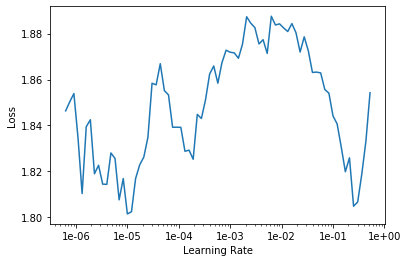

In [30]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [31]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.952191,0.942754,00:08
1,0.881646,0.885450,00:08
2,0.809179,0.836175,00:08
3,0.658536,0.813777,00:08
4,0.576953,0.811007,00:08


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [35]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [36]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [39]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3520),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3236), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2987), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2906),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2614), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2612), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2537), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2531), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2383), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2304), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2205), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2195), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2173), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2091), "McHale's Navy (1997)", 2.1884057971014492),
 (tens

In [40]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5892), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5741), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5661), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5616), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5110), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5103), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5090), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5030), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4943), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4898), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4852), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4812), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4754), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4693), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4570), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [41]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [42]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1698), 'Close Shave, A (1995)'),
 (tensor(1.1102), 'When We Were Kings (1996)'),
 (tensor(1.0963), 'Wrong Trousers, The (1993)'),
 (tensor(1.0837), 'Casablanca (1942)'),
 (tensor(1.0381), 'Lawrence of Arabia (1962)'),
 (tensor(1.0205), 'Ran (1985)'),
 (tensor(1.0110), 'Chinatown (1974)'),
 (tensor(0.9913), '12 Angry Men (1957)'),
 (tensor(0.9644), 'Godfather, The (1972)'),
 (tensor(0.9589), 'Some Folks Call It a Sling Blade (1993)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3422), 'Home Alone 3 (1997)'),
 (tensor(-1.2956), 'Jungle2Jungle (1997)'),
 (tensor(-1.2683), "McHale's Navy (1997)"),
 (tensor(-1.1754), 'Congo (1995)'),
 (tensor(-1.1496), 'Leave It to Beaver (1997)'),
 (tensor(-1.1280), 'Grease 2 (1982)'),
 (tensor(-1.1044), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0962), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0613), 'Bio-Dome (1996)'),
 (tensor(-1.0223), 'Free Willy 3: The Rescue (1997)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [47]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7965), 'Keys to Tulsa (1997)'),
 (tensor(0.7949), 'Trainspotting (1996)'),
 (tensor(0.7796), 'Lost Highway (1997)'),
 (tensor(0.7773), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7540), 'Jude (1996)'),
 (tensor(0.7525), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7450), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7421), 'Cable Guy, The (1996)'),
 (tensor(0.7329), 'Stupids, The (1996)'),
 (tensor(0.7265), 'Brazil (1985)')]

In [48]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1664), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.1182), 'Braveheart (1995)'),
 (tensor(-1.0058), 'Titanic (1997)'),
 (tensor(-0.9024), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8829), 'Pretty Woman (1990)'),
 (tensor(-0.8758), 'Forrest Gump (1994)'),
 (tensor(-0.8693), "It's a Wonderful Life (1946)"),
 (tensor(-0.8650), 'Star Wars (1977)'),
 (tensor(-0.8632), 'Return of the Jedi (1983)'),
 (tensor(-0.8553), "Mr. Holland's Opus (1995)")]

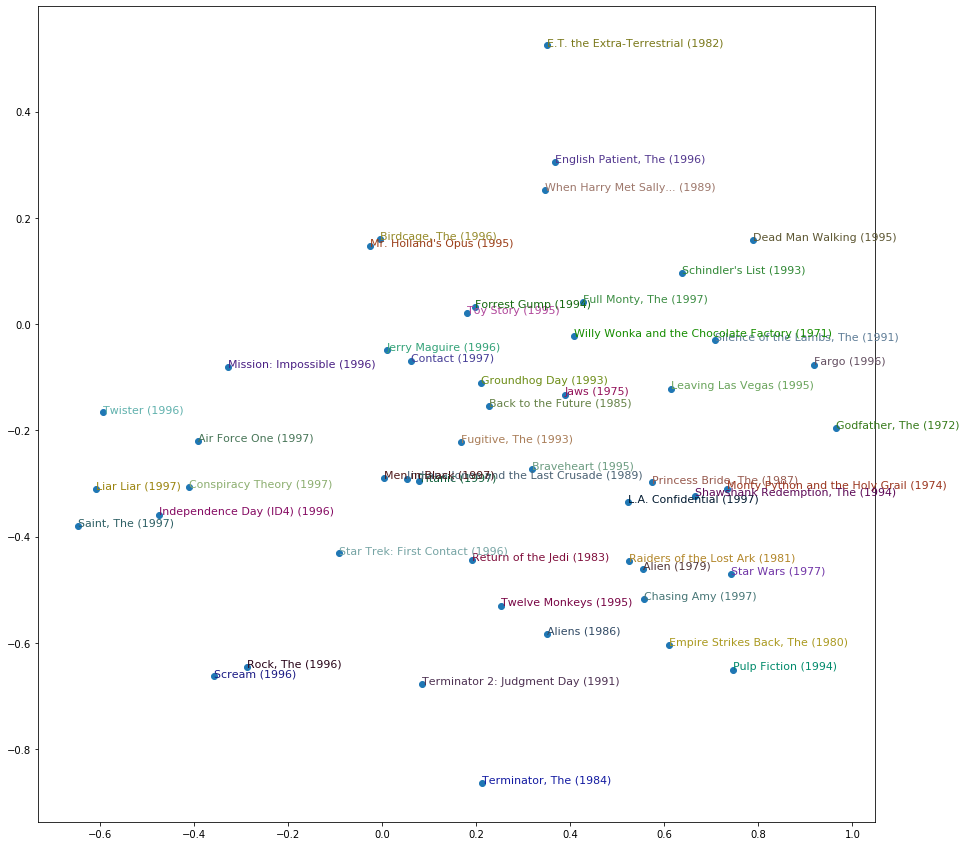

In [49]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()